# PIPELINE TO COMPARE ALGORITHMS
---
---

    def alg tal (image_refs, image_pbs, save_output_plots_path=None):
        ...
        return predicted_delta_phiCRs, times (de cada pairwise image pair ref pb -que están en los mismos indices claro)

Ke guarde los plots ke se outputean si hace falta en ese path dado.

Ta gero funkiño bat que coja algs, que coja image pairs y si acaso coja sus ground-truths como opctional argument, y que te outputee la tabla de imagen, algoritmos delta phicR, delta pol, times, GT, absolute errors.

Ta gero bebai outputee pa cada algoritmo un histograma de los absolute errors y un histograma de tiempos, con las medias y percentiles indicados correctamente.

In [149]:
import os
import json as json
import numpy as np
import pandas as pd
import cv2
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm
from SOURCE.CLASS_CODE_Image_Manager import Image_Manager
from SOURCE.CLASS_CODE_Ad_Hoc_Optimizer import Ad_Hoc_Optimizer
import matplotlib.pyplot as plt
import torch
import h5py
from styleframe import StyleFrame

assert torch.cuda.is_available(), "GPU is not enabled"
# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Pipeline Functions

In [2]:
def angle_to_pi_pi( angle): # convert any angle to range (-pi,pi]\n",
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]\n",
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle


def compute_expectation_CI(empirical_pdf, boots_samples, confidence):
    resamplings=np.random.choice(empirical_pdf, size=( boots_samples, empirical_pdf.shape[0]))
    boot_means=np.mean(resamplings, axis=1)
    boot_stds=np.std(resamplings, axis=1)
    observed_mean=empirical_pdf.mean()
    observed_std=empirical_pdf.std()
    boots_t=(observed_mean-boot_means)*np.sqrt(empirical_pdf.shape[0])/boot_stds
    boots_t_percentiles = np.percentile(boots_t, q=((100-confidence)/2, confidence+(100-confidence)/2))
    return observed_mean+boots_t_percentiles*observed_std/np.sqrt(empirical_pdf.shape[0])


def plot_histograms_for(category, variable, final_results_df, statistic_df, conf, output_path, bins_log=True):
    categories=len(final_results_df.groupby([category])) # category sería algorithm
                            # variable serían time, absolute error etc.
    columns=1 if categories==1 else 2 if (categories==2 or categories==4) else 3
    rows=categories//3+(categories%3!=0)

    fig=plt.figure(figsize=(7*columns, 5*rows))
    if bins_log:
        bins_main_exponents=np.linspace(-8.5, -3.5, 32 ).tolist()
        bins_main_exponents=[1]+bins_main_exponents+[-1,0]
        #bins_main_exponents=[1,-8.5, -8, -7.5, -7, -6.5,-6,-5.5,-5,-4.5,-4,-3.5,-1,0]
        bins_main=10**np.array(bins_main_exponents)
        bins_main[0]=0
    else:
        bins_main=13
    axs=[]
    maxy=0
    for i, (group_var_val, group_df) in enumerate(final_results_df.groupby([category])):
        axs.append(fig.add_subplot(rows,columns, i+1))
        ns, b, p = axs[-1].hist(group_df[variable], bins=bins_main,
                        label=f"{category}={group_var_val}", 
                        rwidth=1, align='mid', edgecolor="k", alpha=0.6) # range=(0,0.4)
        if bins_log:
            axs[-1].set_xscale('log')
        axs[-1].grid(True)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_low'][group_var_val], color='m',
                        linestyle='--', label=f'mean {conf} CI', alpha=0.6)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_up'][group_var_val], color='m', 
                        linestyle='--', alpha=0.6)
        quantiles=np.percentile(group_df[variable], q=((100-conf)/2, conf+(100-conf)/2))
        axs[-1].axvline(x=quantiles[0], color='r', linestyle='--', label=f'{conf} quantiles')
        axs[-1].axvline(x=quantiles[1], color='r', linestyle='--')
        axs[-1].set_title(f"mu {conf}% CI:\n ({statistic_df[variable][f'CI_{conf}_low'][group_var_val]}, \
                          {statistic_df[variable][f'CI_{conf}_up'][group_var_val]})")
        axs[-1].legend()
        maxy = np.max(ns) if np.max(ns)>maxy else maxy
    for ax in axs:
        ax.set_ylim(0,maxy)
    #fig.supylabel('common_y')
    fig.suptitle(f"Histograms for {variable}")
    #fig.suptitle(f"Histogrms for {variable} \n\n Experiment: {experiment_name}\n\n\n The x axes represent the smallest absolute difference between the theoretical\n angle difference and the found angle difference, among the employed algorithms")

    os.makedirs(f"{output_path}/HISTOGRAMS/", exist_ok=True)
    #fig.tight_layout()
    plt.savefig(f"{output_path}/HISTOGRAMS/Histogram_for_{variable}.png", bbox_inches='tight')
    #plt.close()



def run_benchmark_output_result_histograms_and_result_table( algorithm_lambda_list, algorithm_name_list,
                                            references, problems, image_pair_names, generate_algorithm_plots,
                                            generate_histograms, boots_samples=10000, confidence=95,
                                            output_units='rad', ground_truths=None, GT_units=None,
                                            GT_nature = 'phiCR',
                                            experiment_name = None, output_path=None):
    if experiment_name is not None:
        output_path = f"{output_path}/{experiment_name}/"
        os.makedirs(output_path, exist_ok=True)
    # GTs should be in [-pi, pi] or [-180, 180]
    times = {}
    predicted_delta_phiCRs = {}
    
    conv = 180/np.pi if output_units=='deg' else 1
    convGT = 180/np.pi if (output_units=='deg' and GT_units=='rad') else \
        np.pi/180 if (output_units=='rad' and GT_units=='deg') else 1
    print("> Passing Images from each Algorithm...")
    for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
        if output_path is not None and generate_algorithm_plots:
            dir_for_alg = output_path+f"/{alg_name}/"
            os.makedirs( dir_for_alg, exist_ok=True )
        else:
            dir_for_alg = None
        predicted_delta_phiCRs[alg_name], times[alg_name] = algorithm(references, problems, dir_for_alg)
        print(f" - Algorithm {alg_name} done!")
    print("\n> Rearranging results in Tables and outputting to Excels...")
    if output_path is not None:
        json.dump({'image_pair_names':image_pair_names, 'predicted_delta_phiCRs':predicted_delta_phiCRs,
              'times':times}, open( f"{output_path}/RAW_results.json", "w"))
    # Rearrange the result to our desired Table and unit formats
    image_ids = []
    image_names = []
    algorithm_names = []
    delta_phiCRs = []
    delta_pols = []
    timess = []
    GTs = []
    abs_errors = []
    
    for idx, image_pair_name in enumerate(image_pair_names):
        for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
            image_ids.append(idx)
            algorithm_names.append(alg_name)
            image_names.append(image_pair_name)
            delta_phiCRs.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name]) ) 
            delta_pols.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name])/2.0 )
            timess.append(times[alg_name][image_pair_name])
            if ground_truths is not None:
                GTs.append(convGT*ground_truths[idx])
                if GT_nature=='phiCR':
                    abs_errors.append( np.abs(delta_phiCRs[-1]-convGT*ground_truths[idx]) )
                else: # then GT is of polarization
                    abs_errors.append( np.abs(delta_pols[-1]-convGT*ground_truths[idx]) )
                #correct_decimals.append() # beittu HISTOGRAMAGAZ batera zelan eitten zendun hau!
    table_per_image = pd.DataFrame.from_dict({'ID':image_ids, 'Image_Pair_Name':image_names, 'Algorithm':algorithm_names,
                                   'Predicted_Delta_PhiCRs':delta_phiCRs, 'Pred_Delta_Polarizt':delta_pols,
                                   'Times':timess, f'Ground_Truth_{GT_nature}':GTs, 'Absolute_Error':abs_errors})
    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Image_All.pkl")
    print(" - Table per images done!")    
    
    # Group by algorithm and generate statistics by analyte (times, absolute_errors etc.)
    groups = table_per_image.groupby('Algorithm')
    stdv = groups[['Absolute_Error', 'Times']].std().fillna(0.0)
    means = groups[['Absolute_Error', 'Times']].mean()
    # Compute confidence intervals using bootstrap
    CIs_time = {}
    CIs_abs_er = {}
    for alg_name, df in table_per_image.groupby('Algorithm'):
        CIs_time[alg_name] = compute_expectation_CI(df['Times'],boots_samples, confidence)
        CIs_abs_er[alg_name] = compute_expectation_CI(df['Absolute_Error'], boots_samples, confidence)
    CIs_time_df = pd.DataFrame(index=CIs_time.keys(), data=CIs_time.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    CIs_abs_er_df = pd.DataFrame(index=CIs_abs_er.keys(), data=CIs_abs_er.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    
    ae = pd.concat([means['Absolute_Error'], stdv['Absolute_Error'],
                    CIs_abs_er_df[f'CI_{confidence}_l'], CIs_abs_er_df[f'CI_{confidence}_u']],
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    ts = pd.concat([means['Times'], stdv['Times'],
                    CIs_time_df[f'CI_{confidence}_l'], CIs_time_df[f'CI_{confidence}_u']],                   
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    table_per_alg = pd.concat([ae, ts], keys=['Absolute_Error', 'Times'], axis=1)    

    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Algorithm_Statistics.pkl")
        print(" - Table per algorithm done!")    
        if generate_histograms:
            print("\n> Generating histograms...")
            plot_histograms_for('Algorithm', 'Absolute_Error', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            plot_histograms_for('Algorithm', 'Times', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            print("DONE!")
    return table_per_image, table_per_alg

In [3]:
'''
import pandas as pd
table_per_image = pd.DataFrame({'Algorithm':['pene', 'pene2', 'yosif', 'pene', 'yosif'],
                                'Absolute_Error':[0.1, 0.3, 0.04, 0.2, 9], 'Times':[1,3,4,5,6],
                                'Pelikulas':['film', 'bestie', 'zeztrie', 'txistie', 'baijauna'],
                                'Beste_bat':[3.4,23,12,44, 56]       
                        })

groups = table_per_image.groupby('Algorithm')
stdv = groups[['Absolute_Error', 'Times']].std().fillna(0.0)
means = groups[['Absolute_Error', 'Times']].mean()

ae = pd.concat([means['Absolute_Error'], stdv['Absolute_Error']], keys=['Mean', 'Standard_Dev'],axis=1)
ts = pd.concat([means['Times'], stdv['Times']], keys=['Mean', 'Standard_Dev'],axis=1)
a =pd.concat([ae, ts], keys=['Absolute_Error', 'Times'], axis=1)


writer = pd.ExcelWriter('output.xlsx') 
a.to_excel(writer, sheet_name='sheetName', float_format="%.7f", merge_cells=True)

for analyte in a:

    column_length = max(a[analyte].astype(str).map(len).max(), len(analyte[0]+analyte[1]))
    col_idx = a.columns.get_loc(analyte)
    writer.sheets['sheetName'].set_column(col_idx, col_idx, column_length)

writer.save()
'''


'\nimport pandas as pd\ntable_per_image = pd.DataFrame({\'Algorithm\':[\'pene\', \'pene2\', \'yosif\', \'pene\', \'yosif\'],\n                                \'Absolute_Error\':[0.1, 0.3, 0.04, 0.2, 9], \'Times\':[1,3,4,5,6],\n                                \'Pelikulas\':[\'film\', \'bestie\', \'zeztrie\', \'txistie\', \'baijauna\'],\n                                \'Beste_bat\':[3.4,23,12,44, 56]       \n                        })\n\ngroups = table_per_image.groupby(\'Algorithm\')\nstdv = groups[[\'Absolute_Error\', \'Times\']].std().fillna(0.0)\nmeans = groups[[\'Absolute_Error\', \'Times\']].mean()\n\nae = pd.concat([means[\'Absolute_Error\'], stdv[\'Absolute_Error\']], keys=[\'Mean\', \'Standard_Dev\'],axis=1)\nts = pd.concat([means[\'Times\'], stdv[\'Times\']], keys=[\'Mean\', \'Standard_Dev\'],axis=1)\na =pd.concat([ae, ts], keys=[\'Absolute_Error\', \'Times\'], axis=1)\n\n\nwriter = pd.ExcelWriter(\'output.xlsx\') \na.to_excel(writer, sheet_name=\'sheetName\', float_format="%.

# Generic Routines

In [4]:
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image



def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

# PRE-PROCESSING FUNCTIONS

## Numpy in out

In [5]:
def normalize_to_max_saturate_and_iX(images,  saturation_threshold, dtype=np.float64,
                              iX_dev='cpu', out_dev='cpu', X=302): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_max_and_iX(images,  saturation_threshold, dtype=np.float64,
                                     iX_dev='cpu', out_dev='cpu', X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_mean_and_iX(images,  saturation_threshold, dtype=np.float64,
                                      iX_dev='cpu', out_dev='cpu', X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    means = np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_max_and_iX(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=302): # images expected to be [N_images, h, w]
    images= images.astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_and_iX(images, dtype=np.float64,
                     iX_dev='cpu', out_dev='cpu', X=302): # images expected to be [N_images, h, w]
    images = images.astype(dtype)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def sigmoid_lut_and_iX( images, center=0.5, slope_squeezeness=0.085, max_val=255, dtype=np.float64, X=302 ):
    lut = max_val/(1+np.exp(-slope_squeezeness*(np.arange(max_val+1)-center*max_val)))
    images = (lut[ images ]).astype(dtype)
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

## Torch in out

In [6]:
def normalize_to_max_saturate_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_mean_saturate_to_max_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/torch.mean(images, axis=(-1,-2), keepdims=True)
    return compute_raws_to_centered_iXs_torch( images, X, device)


def normalize_to_mean_saturate_to_mean_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    means=torch.mean(images, axis=(-1,-2), keepdims=True)
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_max_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)


def normalize_to_mean_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/torch.mean(images, axis=(-1,-2), keepdims=True), X, device)


def sigmoid_lut_using_numpy_normalize_and_iX( images, in_are_dev, device, center=0.5, 
                       slope_squeezeness=0.085, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=302 ):
    if not in_are_dev:
        images = images.to(device)
    images = (max_val_lut_process*(images.type(torch.float64)/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)))
                 ).type(lut_process_dtype)
    
    lut = (max_val_lut_process/(1+np.exp(-slope_squeezeness*(np.arange(max_val_lut_process+1)-
                                                               center*max_val_lut_process))))
    images = torch.from_numpy(lut[ images.to('cpu').numpy() ]).to(device).type(output_dtype)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=302 ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense


In [7]:
a =torch.flip(torch.arange(14), dims=(0,))
b =torch.arange(12).view(3,4)
print(b.dtype)
b=torch.cat((b,b))
print(a[b])
lut = torch.arange(255).type(torch.uint8)
print(lut,lut[b])

torch.int64
tensor([[13, 12, 11, 10],
        [ 9,  8,  7,  6],
        [ 5,  4,  3,  2],
        [13, 12, 11, 10],
        [ 9,  8,  7,  6],
        [ 5,  4,  3,  2]])
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148

In [8]:
0.085*255

21.675

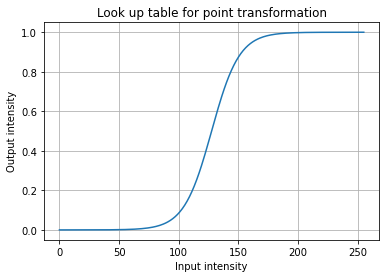

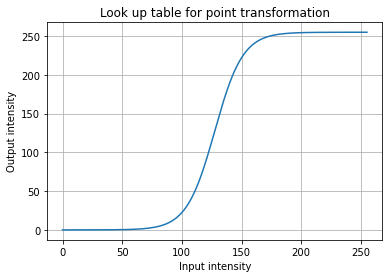

In [9]:
k=22
cent=0.5
lut = 1/(1+np.exp(-k*(np.linspace(0,1,256)-cent)))
plt.plot(lut)
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.title("Look up table for point transformation")
plt.grid()
plt.show()

k=0.085
cent=255*0.5
lut = 255/(1+np.exp(-k*(np.arange(256)-cent)))
plt.plot(lut)
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.title("Look up table for point transformation")
plt.grid()
plt.show()

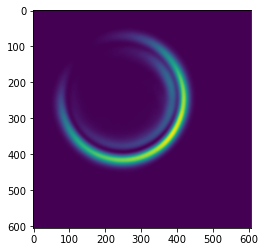

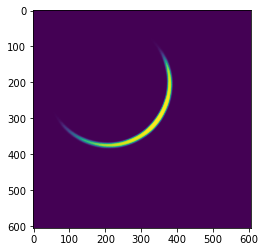

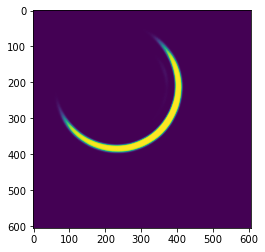

In [10]:
im = cv2.imread( "../EXPERIMENTAL/TEST_IMAGES/con_los_dos.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(im)
plt.show()

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=302 ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)
K=22
k=0.085

out_im = sigmoid_no_lut_normalize_and_iX(torch.from_numpy(im).unsqueeze(0), in_are_dev_float=False, device=device, slope_squeezeness=K)
plt.imshow(out_im[0].to('cpu').numpy())
plt.show()

out_im = sigmoid_lut_using_numpy_normalize_and_iX( torch.from_numpy(im).unsqueeze(0), in_are_dev=False, device=device, center=0.5, 
                       slope_squeezeness=k, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=302 )
plt.imshow(out_im[0].to('cpu').numpy())
plt.show()

# (A) ROTATION ALGORITHM

In [11]:
rotation_alg_kw_args = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}

rotation_preprocess_fct = lambda images:  normalize_to_max_and_iX(images)

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_rotation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, rotation_alg_kw_args, out_plot_path=None, rotation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    image_loader = Image_Manager(mode=X, interpolation_flag=None)
    if rotation_algorithm is None:
        rotation_algorithm = Rotation_Algorithm(image_loader,
            rotation_alg_kw_args['theta_min_Rot'], rotation_alg_kw_args['theta_max_Rot'], 
            rotation_alg_kw_args['interpolation_alg'],
            rotation_alg_kw_args['initial_guess_delta_rad'], rotation_alg_kw_args['use_exact_gravicenter'], 
                                                initialize_it=False)
    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)
    image_loader.import_converted_images_as_array(images, image_names)
    # Execute the Rotation Algorithm:
    rotation_algorithm.interpolation_flag=rotation_alg_kw_args['interpolation_flag']
    rotation_algorithm.reInitialize(image_loader)
    # run it
    if search_algorithm=='quadratic':
        rotation_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        rotation_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    if out_plot_path is not None:
        rotation_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(rotation_algorithm.angles.values())
    ts = list(rotation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i+len(image_pair_names)] + ts[i]
            
    return predicted_deltaPhiCRs, times

# (B) MIRROR FLIP ALGORITHM

In [12]:
mirror_alg_kw_args = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
mirror_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
mirror_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}

mirror_preprocess_fct = lambda images: normalize_to_mean_and_iX(images)
# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_mirror_flip_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, mirror_alg_kw_args, out_plot_path=None, mirror_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    image_loader = Image_Manager(mode=X, interpolation_flag=None)
    if mirror_algorithm is None:
        mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
            mirror_alg_kw_args['theta_min_Mir'], mirror_alg_kw_args['theta_max_Mir'], 
            mirror_alg_kw_args['interpolation_flag'],
            mirror_alg_kw_args['initial_guess_delta_rad'], method="aff", left_vs_right=True, 
            use_exact_gravicenter=mirror_alg_kw_args['use_exact_gravicenter'], initialize_it=False)

    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)
    image_loader.import_converted_images_as_array(images, image_names)
    # Execute the Rotation Algorithm:
    mirror_algorithm.interpolation_flag=mirror_alg_kw_args['interpolation_flag']
    mirror_algorithm.reInitialize(image_loader)
    # run it
    if search_algorithm=='quadratic':
        mirror_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        mirror_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    
    if out_plot_path is not None:
        mirror_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(mirror_algorithm.angles.values())
    ts = list(mirror_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i+len(image_pair_names)] + ts[i]
    
    return predicted_deltaPhiCRs, times

# (C) Simulation Coordinate Descent using h5f library of D matrices

In [13]:
class Simulation_precomputed_R0_w0_Z_Dmatrices_optimize_phiCR():
    def __init__(self,  ID_file_path, D_matrix_file_path, device, coordinate_descent_cycles,
                 min_angle, max_angle, initial_guess_delta_rad, initial_guess_delta_R0,
                 preprocess_fct, similarity, R0_init_guess, w0_init_guess, Z_init_guess,
                 initial_R0_sweep_num, mirror_alg_kw_args):
        import json
        self.D_matrix_file_path = D_matrix_file_path
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.R0s_ar = np.array(self.R0s, dtype=np.float64) # Convert them to float arrays
        self.w0s_ar = np.array(self.w0s, dtype=np.float64)
        self.Zs_ar = np.array(self.Zs, dtype=np.float64)
        self.device = device
        if not hasattr(self, 'h5f_D_matrices'): # this was originally thought for multiprocess child threads to have the chance each to have an open copy of the hdf5 (which should be opened in the first iteration of the parallelized get, not here in the init, but well...)
            self.open_hdf5()
            self.phis = torch.from_numpy(self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(self.device) #[1,Nx,Ny]

        # search function params?
        self.cycles=coordinate_descent_cycles
        self.min_Z=min(self.Zs_ar)
        self.max_Z=max(self.Zs_ar)
        self.min_phi=min_angle
        self.max_phi=max_angle
        self.min_radi=min(self.R0s_ar)
        self.max_radi=max(self.R0s_ar)
        self.min_w0=min(self.w0s_ar)
        self.max_w0=max(self.w0s_ar)
        self.initial_guess_delta_rad=initial_guess_delta_rad
        self.initial_guess_delta_R0=initial_guess_delta_R0
        
        self.R0_precision=abs(self.R0s_ar[1]-self.R0s_ar[0])
        self.w0_precision=abs(self.w0s_ar[1]-self.w0s_ar[0])
        self.Z_precision=abs(self.Zs_ar[1]-self.Zs_ar[0])
        # pa phiCR no porke es unbounded!
        self.angle_optimizer=Ad_Hoc_Optimizer(min_angle, max_angle, initial_guess_delta_rad, self.evaluate_simulation_phi)
        self.radious_optimizer=Ad_Hoc_Optimizer(self.min_radi, self.max_radi, initial_guess_delta_R0, self.evaluate_simulation_R0)
        self.w0_optimizer=Ad_Hoc_Optimizer(self.min_w0, self.max_w0, initial_guess_delta_R0, self.evaluate_simulation_w0)
        self.Z_optimizer=Ad_Hoc_Optimizer(self.min_Z, self.max_Z, initial_guess_delta_R0, self.evaluate_simulation_Z)
        
        self.choose_similarity_alg(similarity)
        
        self.times={}
        self.radious_points={}
        self.w0_points={}
        self.Z_points={}
        self.phi_points={}
        # use the results from the gradient algorithm to initialize the best triplet?
        self.R0_pix_best={}
        self.w0_best={}
        self.Z_best={}
        self.phi_CR_best={}
        self.last_cycle=coordinate_descent_cycles
        self.initial_R0_sweep_num=initial_R0_sweep_num
        self.best_radii={}
        self.best_w0s={}
        self.best_zs={}
        self.best_angles={}
        self.simulations_required={}
        
        self.similarity=similarity # the similarity metric to use as the objective function
        self.preprocess_fct = preprocess_fct
        self.last_R0=None
        self.last_w0=None
        self.last_Z=None
        
        self.R0_init_guess =R0_init_guess
        self.w0_init_guess = w0_init_guess
        self.Z_init_guess = Z_init_guess
        
        image_loader = Image_Manager(mode=X, interpolation_flag=None)
        self.algorithm_M = Mirror_Flip_Algorithm(image_loader,
            mirror_alg_kw_args['theta_min_Mir'], mirror_alg_kw_args['theta_max_Mir'], None,
            mirror_alg_kw_args['initial_guess_delta_rad'], method="aff", left_vs_right=True, 
            use_exact_gravicenter=mirror_alg_kw_args['use_exact_gravicenter'], initialize_it=False)
        
    def __del__(self):
        if hasattr(self, 'h5f_D_matrices'):
            self.h5f_D_matrices.close()
            
    def open_hdf5(self):
        self.h5f_D_matrices = h5py.File( self.D_matrix_file_path, 'r')
        #self.dataset = self.img_hdf5['dataset'] # if you want dataset.

    def angle_to_pi_pi(self, angle): # convert any angle to range ()-pi,pi]
        angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
        return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle
        
    def closest_idx_in_ar(self, value, list_array): # hay que meterle una periodicidad como con los angulos porke los algs de optimizacion están pensados para que así sea
        return (np.abs(list_array-value)).argmin()
        
    def closest_in_ar_periodic(self, value, list_array, delta):
        idxs = (np.round((value-min(list_array))/delta)%len(list_array)).astype(int)
        return list_array[ idxs ]
    
    def plot(self, guess, pb):
        im = torch.cat((guess, pb))
        plt.imshow(im.to('cpu').numpy())
        plt.show()
        
    def get_simulated_image(self, R0, w0, Z, phiCR):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0, self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(self.device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        phiCRs = torch.tensor([self.angle_to_pi_pi(phiCR)]).to(self.device) #[num_phiCR, 1, 1]
        images = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        return self.preprocess_fct(images, in_are_dev_float=True, device=self.device)

    def choose_similarity_alg(self, similarity):
        if similarity == 'mse': # mean square error
            self.similarity_func = lambda im1, im2: torch.sum(torch.square(im1-im2)).item()
        elif similarity == 'mae': # mean absolute error
            self.similarity_func = lambda im1, im2: torch.sum(torch.abs(im1-im2)).item()
        elif similarity == 'mae_pwp':
            self.similarity_func = lambda im1, im2: -torch.sum(im1*im2/torch.max(im1*im2).item()).item()

        
        # NOT TORCHIZISED!
        elif similarity == 'ssim':
            self.similarity_func = lambda im1, im2: -ism.ssim(im1, im2)
        elif similarity == 'fsim':
            self.similarity_func = lambda im1, im2: -ism.fsim(np.expand_dims(im1,2), np.expand_dims(im2,2))
        elif similarity == 'issm':
            self.similarity_func = lambda im1, im2: ism.issm(im1, im2)
        elif similarity == 'sre':
            self.similarity_func = lambda im1, im2: -ism.sre(np.expand_dims(im1,2), np.expand_dims(im2,2))
        elif similarity == 'sam':
            self.similarity_func = lambda im1, im2: -ism.sam(np.expand_dims(im1,2), np.expand_dims(im2,2))
        elif similarity == 'uiq':
            self.similarity_func = lambda im1, im2: -ism.uiq(np.expand_dims(im1,2), np.expand_dims(im2,2))
        # ADD DL trained Similarity Metric!

        
    def reInitialize_and_input_images(self, images, image_names,
                     preprocess_fct=None, coordinate_descent_cycles=None, similarity=None,
                    R0_init_guess=None, w0_init_guess=None, Z_init_guess=None): 
        if type(images)!=torch.Tensor:
            images = torch.from_numpy(images).to(self.device)            
        self.images = self.preprocess_fct(images, in_are_dev_float=False, device=self.device)
        self.image_names = image_names
        self.times={}
        self.radious_points={}
        self.w0_points={}
        self.Z_points={}
        self.phi_points={}
        self.R0_pix_best={}
        self.w0_best={}
        self.Z_best={}
        self.phi_CR_best={}
        self.last_cycle=coordinate_descent_cycles

        self.best_radii={}
        self.best_w0s={}
        self.best_zs={}
        self.best_angles={}
        self.simulations_required={}
        
        self.last_R0=None
        self.last_w0=None
        self.last_Z=None

        image_loader_for_M = Image_Manager(mode=X, interpolation_flag=None)
        image_loader_for_M.import_converted_images_as_array( self.images.to('cpu').numpy(), self.image_names )
        self.algorithm_M.reInitialize(image_loader_for_M)
        
        if similarity is not None:
            self.similarity=similarity
            self.choose_similarity_alg(similarity)
        if preprocess_fct is not None:
            self.preprocess_fct = preprocess_fct
        if coordinate_descent_cycles is not None:
            self.cycles=coordinate_descent_cycles
        if R0_init_guess is not None:
            self.R0_init_guess = R0_init_guess
        if w0_init_guess is not None:
            self.w0_init_guess = w0_init_guess
        if Z_init_guess is not None:
            self.Z_init_guess = Z_init_guess

    def evaluate_simulation_phi(self, exp_image, phiCR, R0_best, Z_best, w0_best): # exp im expected to be [1,h,w]
        return self.similarity_func(exp_image, self.get_simulated_image(R0_best, w0_best, Z_best, phiCR))

    def evaluate_simulation_R0(self, exp_image, R0, angle_best, Z_best, w0_best):
        return self.similarity_func(exp_image, self.get_simulated_image(R0, w0_best, Z_best, angle_best))


    def evaluate_simulation_Z(self, exp_image, Z, angle_best, R0_best, w0_best):
        return self.similarity_func(exp_image, self.get_simulated_image(R0_best, w0_best, Z, angle_best))


    def evaluate_simulation_w0(self, exp_image, w0, angle_best, R0_best, Z_best):
        return self.similarity_func(exp_image, self.get_simulated_image(R0_best, w0, Z_best, angle_best))

    def initial_sweep_R0(self, exp_image, phiCR, Z, w0):
        R0s_to_try = self.R0s[::len(self.R0s)//self.initial_R0_sweep_num]
        costs=[self.evaluate_simulation_R0(exp_image, float(R0), phiCR, Z, w0) for R0 in R0s_to_try]
        return float(R0s_to_try[np.argmin(costs)])
        

    def fibonacci_ratio_search(self, precision_R0, maximum_points_R0, precision_phi,
        maximum_points_phi, precision_Z, maximum_points_Z,  precision_w0, maximum_points_w0, cost_tol,
        precision_M, maximum_points_M, cost_tol_M):
        # We first find an estimation for phiCR using the mirror flip algorithm
        self.algorithm_M.fibonacci_ratio_search(precision_M, maximum_points_M, cost_tol_M)
        
        # We now execute a sequence of linear optimizations for each coordinate for every cycle and image
        for im, name in enumerate(self.image_names):
            self.times[name]={}
            self.radious_points[name]={}
            self.Z_points[name]={}
            self.w0_points[name]={}
            self.phi_points[name]={}
            # use the results from the gradient algorithm to initialize the best triplet
            #self.R0_pix_best[name]=[1.65*abs(self.algorithm_G.optimals[f'Fibonacci_Search_{name}'])]
            self.R0_pix_best[name]=[self.R0_init_guess]
            self.Z_best[name]=[self.Z_init_guess]
            self.w0_best[name]=[self.w0_init_guess]
            # Initialize the phiCR with the result from the mirror flip agorithm
            self.phi_CR_best[name]=[self.algorithm_M.angles[f'Fibonacci_Search_{name}']]
            # Make an initial sweep of R0 to get a good enough initial guess
            self.R0_pix_best[name]=[self.initial_sweep_R0( self.images[im], self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1])]
            simulations=0
            for cycle in range(self.cycles):
                # Optimize Radious
                (time_rad, self.radious_points[name][cycle], R0_pix_best, radi_optimum,
                 _)=self.radious_optimizer.fibonacci_ratio_search(
                    precision_R0, maximum_points_R0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1]), self.R0_pix_best[name][-1]
                )
                self.radious_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.radious_points[name][cycle][:,0], self.R0s_ar, self.R0_precision)
                R0_pix_best = self.closest_in_ar_periodic(R0_pix_best, self.R0s_ar, self.R0_precision)
                
                # Optimize w0 - the width of the croissant
                (time_w0, self.w0_points[name][cycle], w0_best, w0_optimum,
                 _)=self.w0_optimizer.fibonacci_ratio_search(
                    precision_w0, maximum_points_w0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], R0_pix_best, self.Z_best[name][-1]), self.w0_best[name][-1]
                )
                self.w0_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.w0_points[name][cycle][:,0], self.w0s_ar, self.w0_precision)
                w0_best = self.closest_in_ar_periodic(w0_best, self.w0s_ar, self.w0_precision)
                 
                # Optimize Z
                if maximum_points_Z!=0:
                    self.Z_optimizer.a=-2*np.sqrt(1/3)*w0_best
                    self.Z_optimizer.b=-self.Z_optimizer.a
                    (time_Z, self.Z_points[name][cycle], Z_best, Z_optimum,
                        _)=self.Z_optimizer.fibonacci_ratio_search(
                            precision_Z, maximum_points_Z, cost_tol,
                            self.images[im].unsqueeze(0),
                            (self.phi_CR_best[name][-1], R0_pix_best, w0_best), self.Z_best[name][-1]
                        )
                    self.Z_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.Z_points[name][cycle][:,0], self.Zs_ar, self.Z_precision)
                    Z_best = self.closest_in_ar_periodic(Z_best, self.Zs_ar, self.Z_precision)
                
                else: # dont optimize z
                    time_Z=0
                    Z_best=0
                    Z_optimum=0
                    self.Z_points[name][cycle]=np.array([[0,0,0]])
                
                # Optimize Angle
                (time_ang, self.phi_points[name][cycle], phi_CR_best, phi_optimum, _)=self.angle_optimizer.fibonacci_ratio_search(
                    precision_phi, maximum_points_phi, cost_tol,
                    self.images[im].unsqueeze(0),
                    (R0_pix_best, Z_best, w0_best), self.phi_CR_best[name][-1]
                )
                
                self.times[name][cycle]=time_rad+time_ang+time_Z+time_w0
                self.R0_pix_best[name].append(R0_pix_best)
                self.phi_CR_best[name].append(phi_CR_best)
                self.w0_best[name].append(w0_best)
                self.Z_best[name].append(Z_best)

                simulations+=len(self.phi_points[name][cycle])+len(self.radious_points[name][cycle])+len(self.Z_points[name][cycle])+len(self.w0_points[name][cycle])

                # check if convergence criterion is met
                if((abs(Z_optimum-phi_optimum)<cost_tol and
                        abs(phi_optimum-radi_optimum)<cost_tol and
                            abs(radi_optimum-w0_optimum)<cost_tol)
                        or (abs(self.R0_pix_best[name][-2]-R0_pix_best)<precision_R0 and
                        abs(self.phi_CR_best[name][-2]-phi_CR_best)<precision_phi and
                        abs(self.Z_best[name][-2]-Z_best)<precision_Z) and
                        abs(self.w0_best[name][-2]-w0_best<precision_w0)):
                    self.last_cycle=cycle+1
                    break
            self.best_radii[name]=R0_pix_best
            self.best_w0s[name]=w0_best
            self.best_zs[name]=Z_best
            self.best_angles[name]=self.angle_to_pi_pi(phi_CR_best)
            self.simulations_required[name]=simulations
            print(f"Image {im} optimized!")


    def quadratic_fit_search(self, precision_R0, maximum_points_R0, precision_phi,
        maximum_points_phi, precision_Z, maximum_points_Z, precision_w0, maximum_points_w0, cost_tol,
        precision_M, maximum_points_M, cost_tol_M):
        # We first find an estimation for R0 and phiCR using the gradient algorithm
        self.algorithm_M.quadratic_fit_search(precision_M, maximum_points_M, cost_tol_M)

        # We now execute a sequence of linear optimizations for each coordinate for every cycle
        for im, name in enumerate(self.image_names):
            self.times[name]={}
            self.radious_points[name]={}
            self.Z_points[name]={}
            self.w0_points[name]={}
            self.phi_points[name]={}
            # use the results from the gradient algorithm to initialize the best triplet
            #self.R0_pix_best[name]=[1.65*abs(self.algorithm_G.optimals[f'Fibonacci_Search_{name}'])]
            self.R0_pix_best[name]=[self.R0_init_guess]
            self.Z_best[name]=[self.Z_init_guess]
            self.w0_best[name]=[self.w0_init_guess]
            # Initialize the phiCR with the result from the mirror flip agorithm
            self.phi_CR_best[name]=[self.algorithm_M.angles[f'Quadratic_Search_{name}']]
            # Make an initial sweep of R0 to get a good enough initial guess
            self.R0_pix_best[name]=[self.initial_sweep_R0( self.images[im], self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1])]
            simulations=0
            for cycle in range(self.cycles):
               
                # Optimize Radious
                (time_rad, self.radious_points[name][cycle], R0_pix_best, radi_optimum,
                 _)=self.radious_optimizer.quadratic_fit_search(
                    precision_R0, maximum_points_R0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1]), self.R0_pix_best[name][-1]
                )
                self.radious_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.radious_points[name][cycle][:,0], self.R0s_ar, self.R0_precision)
                R0_pix_best = self.closest_in_ar_periodic(R0_pix_best, self.R0s_ar, self.R0_precision)
                
                # Optimize w0 magnitude - the width of the croissant
                (time_w0, self.w0_points[name][cycle], w0_best, w0_optimum,
                 _)=self.w0_optimizer.quadratic_fit_search(
                    precision_w0, maximum_points_w0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], R0_pix_best, self.Z_best[name][-1]), self.w0_best[name][-1]
                )
                self.w0_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.w0_points[name][cycle][:,0], self.w0s_ar, self.w0_precision)
                w0_best = self.closest_in_ar_periodic(w0_best, self.w0s_ar, self.w0_precision)

                # Optimize Z
                if maximum_points_Z!=0:
                    self.Z_optimizer.a=-2*np.sqrt(1/3)*R0_pix_best*self.simulator.dx
                    self.Z_optimizer.b=-self.Z_optimizer.a
                    (time_Z, self.Z_points[name][cycle], Z_best, Z_optimum,
                        _)=self.Z_optimizer.quadratic_fit_search(
                            precision_Z, maximum_points_Z, cost_tol,
                            self.images[im].unsqueeze(0),
                            (self.phi_CR_best[name][-1], R0_pix_best, w0_best), self.Z_best[name][-1]
                        )
                    self.Z_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.Z_points[name][cycle][:,0], self.Zs_ar, self.Z_precision)
                    Z_best = self.closest_in_ar_periodic(Z_best, self.Zs_ar, self.Z_precision)
                
                else: # dont optimize z
                    time_Z=0
                    Z_best=0
                    Z_optimum=0
                    self.Z_points[name][cycle]=np.array([[0,0,0]])
                
                # Optimize Angle
                (time_ang, self.phi_points[name][cycle], phi_CR_best, phi_optimum, _)=self.angle_optimizer.quadratic_fit_search(
                    precision_phi, maximum_points_phi, cost_tol,
                    self.images[im].unsqueeze(0),
                    (R0_pix_best, Z_best, w0_best), self.phi_CR_best[name][-1]
                )

                self.times[name][cycle]=time_rad+time_ang+time_Z+time_w0
                self.R0_pix_best[name].append(R0_pix_best)
                self.w0_best[name].append(w0_best)
                self.phi_CR_best[name].append(phi_CR_best)
                self.Z_best[name].append(Z_best)

                simulations+=len(self.phi_points[name][cycle])+len(self.radious_points[name][cycle])+len(self.Z_points[name][cycle])+len(self.w0_points[name][cycle])

                # check if convergence criterion is met
                if((abs(Z_optimum-phi_optimum)<cost_tol and
                        abs(phi_optimum-radi_optimum)<cost_tol and
                            abs(radi_optimum-w0_optimum)<cost_tol)
                        or (abs(self.R0_pix_best[name][-2]-R0_pix_best)<precision_R0 and
                        abs(self.phi_CR_best[name][-2]-phi_CR_best)<precision_phi and
                        abs(self.Z_best[name][-2]-Z_best)<precision_Z) and
                        abs(self.w0_best[name][-2]-w0_best<precision_w0)):
                    self.last_cycle=cycle+1
                    break
            self.best_radii[name]=R0_pix_best
            self.best_w0s[name]=w0_best
            self.best_zs[name]=Z_best
            self.best_angles[name]=self.angle_to_pi_pi(phi_CR_best)
            self.simulations_required[name]=simulations
            print(f"Image {im} optimized!")

    def plot_best_found_ones(self, out_path):
        os.makedirs(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/", exist_ok=True)
        fig = plt.figure(figsize=(2*4.5, len(self.image_names)*4.5))
        axes=fig.subplots(len(self.image_names),2)
        if len(axes.shape)==1:
            axes=np.expand_dims(axes, 0)
        for k, (name, optimal_angle) in enumerate(self.best_angles.items()):
            axes[k, 0].imshow(self.images[k].to('cpu').numpy())        
            axes[k, 1].imshow(self.get_simulated_image( R0=self.best_radii[name],
                w0=self.best_w0s[name], Z=self.best_zs[name], phiCR=self.best_angles[name]).to('cpu').numpy()[0])
            axes[k,0].set_title(f"Experimental Image {name}\nOptimal phiCR {optimal_angle}")
            axes[k,1].set_title(f"Fitted Image: \nR0={self.best_radii[name]}pix w0={self.best_w0s[name]}pix\n Z={self.best_zs[name]}pix phiCR={self.best_angles[name]}rad")
        fig.suptitle("Results of the Simulation Coordinate Descent Algorithm")
        plt.savefig(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/Net_Results.png")
        
    def save_result_plots(self, out_path, meth_name):
        os.makedirs(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/", exist_ok=True)
        self.algorithm_M.save_result_plots_fibonacci_or_quadratic(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/")
        fig = plt.figure(figsize=(4*10, 10*self.last_cycle))

        for k, name in enumerate(self.phi_points.keys()):
            axes = fig.subplots(self.last_cycle, 4)
            if self.last_cycle==1:
                axes=np.expand_dims(axes,0)
            for cycle in range(self.last_cycle):
                axes[cycle, 0].plot(self.w0_points[name][cycle][:,0], self.w0_points[name][cycle][:,1], 'o', label=f'w0 pixels descent fixing phiCR={self.phi_CR_best[name][cycle]}; R0 pix={self.R0_pix_best[name][cycle]}; Z={self.Z_best[name][cycle]}')
                axes[cycle, 1].plot(self.radious_points[name][cycle][:,0], self.radious_points[name][cycle][:,1], 'o', label=f'R0 pixels descent fixing w0 pix ={self.w0_best[name][cycle+1]}; phiCR={self.phi_CR_best[name][cycle]}; Z={self.Z_best[name][cycle]}')
                axes[cycle, 2].plot(self.phi_points[name][cycle][:,0], self.phi_points[name][cycle][:,1], 'o', label=f'phiCR descent fixing w0 pix ={self.w0_best[name][cycle+1]}; R0 pix={self.R0_pix_best[name][cycle+1]}; Z={self.Z_best[name][cycle]}')
                axes[cycle, 3].plot(self.Z_points[name][cycle][:,0], self.Z_points[name][cycle][:,1], 'o', label=f'Z descent fixing w0 pix ={self.w0_best[name][cycle+1]}; R0 pix={self.R0_pix_best[name][cycle+1]}; phiCR={self.phi_CR_best[name][cycle+1]}')

                axes[cycle, 0].set_xlabel("w0 (pixels)")
                axes[cycle, 1].set_xlabel("R0 (pixels)")
                axes[cycle, 2].set_xlabel("phi_CR (rad)")
                axes[cycle, 3].set_xlabel("Z (w0-s)")
                axes[cycle, 0].set_title(f"Best of cycle={self.w0_best[name][cycle+1]}\n Computed points={len(self.w0_points[name][cycle])}")
                axes[cycle, 1].set_title(f"Best of cycle={self.R0_pix_best[name][cycle+1]}\n Computed points={len(self.radious_points[name][cycle])}")
                axes[cycle, 2].set_title(f"Best of cycle={self.phi_CR_best[name][cycle+1]}\n Computed points={len(self.phi_points[name][cycle])}")
                axes[cycle, 3].set_title(f"Best of cycle={self.Z_best[name][cycle+1]}\n Computed points={len(self.Z_points[name][cycle])}")

                for i in range(4):
                    axes[cycle, i].set_ylabel("sum(abs(simulated_image(phiCR, R0_pix, w0_pix, Z)-exp_image))")
                    axes[cycle, i].grid(True)
                    axes[cycle, i].legend()

                fig.suptitle(f"{meth_name}  {name}\nBest triplet: phiCR={self.best_angles[name]}rad; R0_pix={self.best_radii[name]}pix; w0={self.best_w0s[name]}(pix); Z={self.best_zs[name]}w0")
            plt.savefig(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/{meth_name}__{name}.png")
            fig.clf()
            I=self.get_simulated_image( R0=self.best_radii[name],
                w0=self.best_w0s[name], Z=self.best_zs[name], phiCR=self.best_angles[name]).to('cpu').numpy()
            I = (255*I/I.max())[0] #[h,w]
            cv2.imwrite(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/iX_{X}_Left_Exp_[{name}]_Right_Simul_PolAngle_{self.best_angles[name]/2:.15f}_CRAngle_{self.best_angles[name]:.15f}_Z_{self.best_zs[name]}_R0_pix_{self.best_radii[name]}_w0_pix_{self.best_w0s[name]}.png",
                np.concatenate((I, (255*(self.images[k].type(torch.float64)/self.images[k].max())).to('cpu').numpy()),axis=1))

In [14]:
#ID_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
#D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Encoder_Alone/Dataset_R0_70_w0_70_Z_4.h5"
ID_file_path = "/media/melanie/D459-5113/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path = "/media/melanie/D459-5113/Dataset_R0_70_w0_70_Z_4.h5"

mirror_alg_sim_kw_args = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.4, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}

simulation_alg_kw_args = {'ID_file_path':ID_file_path, 'D_matrix_file_path':D_matrix_file_path, 'device':device, 
                        'coordinate_descent_cycles':3, 'min_angle':-np.pi,
                       'max_angle':np.pi,'initial_guess_delta_rad':0.1, 'initial_guess_delta_R0':1,
                        'similarity':'mae','R0_init_guess':158.0, 'w0_init_guess':25.0, 'Z_init_guess':0.0,
                          'initial_R0_sweep_num':10
                       }
simulation_fibo_kw_args = {'precision_R0':1e-10, 'maximum_points_R0':20, 'precision_phi':1e-10,
                        'maximum_points_phi':100, 'precision_Z':1e-2, 'maximum_points_Z':0, 
                         'precision_w0':1e-10, 'maximum_points_w0':20, 'cost_tol':1e-14, 'precision_M':1e-4,
                        'maximum_points_M':100, 'cost_tol_M':1e-14}

simulation_quad_kw_args = {'precision_R0':1e-10, 'maximum_points_R0':20, 'precision_phi':1e-10,
                        'maximum_points_phi':100, 'precision_Z':1e-2, 'maximum_points_Z':0, 
                         'precision_w0':1e-10, 'maximum_points_w0':20, 'cost_tol':1e-14, 'precision_M':1e-4,
                        'maximum_points_M':100, 'cost_tol_M':1e-14}

simulation_preprocess_fct = lambda images, in_are_dev_float, device : normalize_to_mean_saturate_to_max_and_iX_torch(images, \
                                            in_are_dev_float,  device=device,  dtype=torch.float64, X=302,
                                            saturation_threshold=torch.tensor([0.1], device=device))

simulation_preprocess_fct = lambda images, in_are_dev_float, device : normalize_to_max_and_iX_torch(images, 
                                                                                    in_are_dev_float, device=device)


# also, at least in this case, expected to be torch arrays!
def run_simulation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, simulation_alg_kw_args,mirror_alg_kw_args,
                             out_plot_path=None, simulation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    if simulation_algorithm is None:
        simulation_algorithm = Simulation_precomputed_R0_w0_Z_Dmatrices_optimize_phiCR(
            ID_file_path=simulation_alg_kw_args['ID_file_path'], 
            D_matrix_file_path=simulation_alg_kw_args['D_matrix_file_path'], device=simulation_alg_kw_args['device'],
            coordinate_descent_cycles=simulation_alg_kw_args['coordinate_descent_cycles'],
            min_angle=simulation_alg_kw_args['min_angle'], max_angle=simulation_alg_kw_args['max_angle'], 
            initial_guess_delta_rad=simulation_alg_kw_args['initial_guess_delta_rad'], 
            initial_guess_delta_R0=simulation_alg_kw_args['initial_guess_delta_R0'],
            preprocess_fct=preprocess_fct, similarity=simulation_alg_kw_args['similarity'],
            R0_init_guess=simulation_alg_kw_args['R0_init_guess'], w0_init_guess=simulation_alg_kw_args['w0_init_guess'], 
            Z_init_guess=simulation_alg_kw_args['Z_init_guess'],initial_R0_sweep_num=simulation_alg_kw_args['initial_R0_sweep_num'],
            mirror_alg_kw_args=mirror_alg_kw_args
            )
    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if type(references)!=torch.Tensor and type(problems)!=torch.Tensor:
        images = np.concatenate((references, problems), axis=0)
        images = torch.from_numpy(images).to(device)
    else:
        images = torch.cat((references, problems), dim=0)

    # Execute the Rotation Algorithm:
    simulation_algorithm.reInitialize_and_input_images( images, image_names,
                     preprocess_fct=preprocess_fct, coordinate_descent_cycles=simulation_alg_kw_args['coordinate_descent_cycles'],
                    similarity=simulation_alg_kw_args['similarity'],
                R0_init_guess=simulation_alg_kw_args['R0_init_guess'],
                w0_init_guess=simulation_alg_kw_args['w0_init_guess'],
                Z_init_guess=simulation_alg_kw_args['Z_init_guess'])
    # run it
    if search_algorithm=='quadratic':
        simulation_algorithm.quadratic_fit_search(precision_R0=search_alg_kw_args['precision_R0'],
            maximum_points_R0=search_alg_kw_args['maximum_points_R0'], precision_phi=search_alg_kw_args['precision_phi'],
            maximum_points_phi=search_alg_kw_args['maximum_points_phi'], precision_Z=search_alg_kw_args['precision_Z'], 
            maximum_points_Z=search_alg_kw_args['maximum_points_Z'],  precision_w0=search_alg_kw_args['precision_w0'],
            maximum_points_w0=search_alg_kw_args['maximum_points_w0'], cost_tol=search_alg_kw_args['cost_tol'],
            precision_M=search_alg_kw_args['precision_M'], maximum_points_M=search_alg_kw_args['maximum_points_M'],
                                                  cost_tol_M=search_alg_kw_args['cost_tol_M'])
        if out_plot_path is not None:
            simulation_algorithm.save_result_plots(out_plot_path, 'Quadratic')
    else: # 'fibo'
        simulation_algorithm.fibonacci_ratio_search(precision_R0=search_alg_kw_args['precision_R0'],
            maximum_points_R0=search_alg_kw_args['maximum_points_R0'], precision_phi=search_alg_kw_args['precision_phi'],
            maximum_points_phi=search_alg_kw_args['maximum_points_phi'], precision_Z=search_alg_kw_args['precision_Z'], 
            maximum_points_Z=search_alg_kw_args['maximum_points_Z'],  precision_w0=search_alg_kw_args['precision_w0'],
            maximum_points_w0=search_alg_kw_args['maximum_points_w0'], cost_tol=search_alg_kw_args['cost_tol'],
            precision_M=search_alg_kw_args['precision_M'], maximum_points_M=search_alg_kw_args['maximum_points_M'],
                                                  cost_tol_M=search_alg_kw_args['cost_tol_M'])    
        if out_plot_path is not None:
            simulation_algorithm.save_result_plots(out_plot_path, 'Fibonacci')

    if out_plot_path is not None:
        simulation_algorithm.plot_best_found_ones(out_plot_path)
    
    angles = list(simulation_algorithm.best_angles.values())
    ts = list(simulation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = sum(ts[i+len(image_pair_names)].values()) + sum(ts[i].values())
    
    return predicted_deltaPhiCRs, times

# (D) Naive Affine Rotation

In [ ]:
class Naive_Affine_Rotation(Polarization_Obtention_Algorithm):
    def __init__(self, X, min_angle, max_angle, interpolation_flag, initial_guess_delta, use_exact_gravicenter):
        #Polarization_Obtention_Algorithm.__init__(self,image_loader, use_exact_gravicenter)
        #self.original_images = image_loader
        self.mode = X
        self.use_exact_gravicenter=use_exact_gravicenter
        self.angles={}
        self.precisions={}
        
        self.interpolation_flag = interpolation_flag
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.initial_guess_delta = initial_guess_delta
        self.computed_points={}
        self.optimums={}
        self.optimals={}
        self.times={}
        self.cols=np.broadcast_to( np.arange(self.mode*2+1), (self.mode*2+1,self.mode*2+1)) #[h,w]
        self.optimizer = Ad_Hoc_Optimizer(min_angle, max_angle, initial_guess_delta, self.evaluate_image_rotation)
        
    def reInitialize_and_input_images(self, ref_images, pb_images, image_pair_names):     
        # Reference image in position k is the reference for the problem image in position k
        # both arrays will be [N_im, H,W]            
        self.reference_images = ref_images
        self.problem_images = pb_images
        self.image_names = image_pair_names
        
        self.angles={}
        self.precisions={}
        self.computed_points={}
        self.optimums={}
        self.optimals={}
        self.times={}
        self.cols=np.broadcast_to( np.arange(self.mode*2+1), (self.mode*2+1,self.mode*2+1)) #[h,w]
        
        if self.use_exact_gravicenter: # GRAVICENTRUM KALKULEU!
            self.grav_ref = self.compute_intensity_gravity_centers(reference_images) #[N_images, 2(h,w)]
            self.grav_pb = self.compute_intensity_gravity_centers(problem_images)
        else:
            # gravicenter the same for all
            self.grav=np.array(2*[self.x])+0.5

    def angle_to_pi_pi(self, angle): # convert any angle to range ()-pi,pi]
        angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
        return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle

    
    def compute_intensity_gravity_centers(self, images):
        """
            Expects input images to be an array of dimensions [N_images, h, w].
            It will return an array of gravity centers [N_images, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to numpy indices, so they being at 0
        """
        # image wise total intensity and marginalized inensities for weighted sum
        # (preserves axis 0, where images are stacked)
        intensity_in_w = np.sum(images, axis=1) # weights for x [N_imgs, raw_width]
        intensity_in_h = np.sum(images, axis=2) # weights for y [N_imgs, raw_height]
        total_intensity = intensity_in_h.sum(axis=1)

        # Compute mass center for intensity (in each image axis)
        # [N_images, 2] (h_center,w_center)
        return np.nan_to_num( np.stack(
            (np.dot(intensity_in_h, np.arange(images.shape[-2]))/total_intensity,
             np.dot(intensity_in_w, np.arange(images.shape[-1]))/total_intensity)
            ).transpose() )

    def rotate_image_by(self, image_array, angle, center):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=self.interpolation_flag).astype(image_array.dtype)
     
    def translate_image_and_rotate_by(self, image_array, angle, rotation_center, translation):
        """
        first translation then rotation about that special center is done
        rotation_center is expected to be a point [h,w]
        the translation is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64(
                [[a, b, translation[1]*a+translation[0]*b+rotation_center[1]*(1-a)-rotation_center[0]*b],
                 [-b, a, -translation[1]*b+translation[0]*a+rotation_center[1]*b+rotation_center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=self.interpolation_flag).astype(image_array.dtype)


    def evaluate_image_rotation(self, reference_image, angle, image_to_rotate, center_ref, center_pb):
        return np.sum(np.abs(self.translate_image_and_rotate_by(
                                image_to_rotate, angle, center_ref, center_ref-center_pb)
                             -reference_image))


    def given_axis_angle_greater_minus_lower(self, angle, image, center):
        # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
        # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
        mask=np.less(self.cols.swapaxes(0,1), np.tan(-angle)*(self.cols-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
            # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
        return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

    def get_polarization_angle(self, angle, image, center):
        """
        All the mirror methods have the problem that we only get the
        correct angle up to an angle pi. In order to know which is the
        angle to the maximum of the ring (and not the minimum) a final
        subtle check is required.
        """
        #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        diff=self.given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center)

        if diff>0: # then Upper>Lower -> then good one is the one in (0,pi)
            return angle+np.pi if angle<0 else angle
        else:
            return angle-np.pi if angle>0 else angle

    def brute_force_search(self, angle_steps, zoom_ratios):
        """
        What does this exactly do

        Arguments
        --------
        - angle_steps (list): A list of the different angle steps to take in each of the sweeps.
            Expected N, where N is the number of sweeps that will be performed. The first one is
            expected to be the coarsest grain and they should be ordered from big to smallest.
            The last step in the list will define the precision of the found minimum. The angle
            steps are expected to be in (0, 2pi)

        - zoom_ratios (list): A list of the interval reductions that will be held after each sweep
            around the current best candidate for the minimum. There should be N-1 elements and
            they should be numbers in (0,1].

        """
        zoom_ratios.append(1) #to avoid out of index in the last iteration
        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Brute_Force_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            self.optimals[name],
            self.optimums[name],
            self.precisions[name]) = self.optimizer.brute_force_search(
                    angle_steps, zoom_ratios,
                    self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav
                            ))
            self.optimals[name][f"Stage_{len(angle_steps)-1}"] =self.angle_to_pi_pi(self.optimals[name][f"Stage_{len(angle_steps)-1}"])
            self.angles[name]=self.get_polarization_angle(self.optimals[name][f"Stage_{len(angle_steps)-1}"]/2, self.images_float[im],
                self.grav[im] if self.use_exact_gravicenter else self.grav
            )


    def fibonacci_ratio_search(self, precision, maximum_points, cost_tol):
        """
        Arguments
        --------
        - precision (float): Half the length of the interval achieved in the last step. It will be
            the absolute error to which we compute the minimum of the funtion. Note however that
            the precision will have a minimum depending on the image quality and the minimum
            rotation arithmetics. Noise or discretization can induce plateaus in the minimum.
            Therefore, if at some point the three points have the same cost function the algorithm
            will stop: the cost function has arrived to the plateau. In that case the precision will
            be outputed accordingly.

        - maximum_points (int): Maximum number of points to use in the minimum search. It is also
            the number of times to make an interval reduction.

        - cost_tol (float): Maximum relative difference between the cost function active points
            tolerated before convergence assumption.
        """

        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Fibonacci_Search_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            optimal,
            self.optimums[name],
            self.precisions[name])=         self.optimizer.fibonacci_ratio_search(
                    precision, maximum_points, cost_tol,
                    self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav
                                                                   ))
            self.optimals[name]=self.angle_to_pi_pi(optimal)
            #self.angles[name]=self.get_polarization_angle(self.optimals[name]/2, self.images_float[im],
            #    self.grav[im] if self.use_exact_gravicenter else self.grav)
            self.angles[name]=self.optimals[name]/2

    def quadratic_fit_search(self, precision, max_iterations, cost_tol):
        """
        Quadratic

        Arguments
        --------
        - precision (float): Half the length of the interval achieved in the last step. It will be
            the absolute error to which we compute the minimum of the funtion. Note however that
            the precision will have a minimum depending on the image quality and the minimum
            rotation arithmetics. Noise or discretization can induce plateaus in the minimum.
            Therefore, if at some point the three points have the same cost function the algorithm
            will stop: the cost function has arrived to the plateau. In that case the precision will
            be outputed accordingly.

        - max_iterations (int): Number of maximum iterations of quadratic function fit and
            minimization to tolerate.

        - cost_tol (float): Maximum relative difference between the cost function active points
            tolerated before convergence assumption.

        """
        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Quadratic_Search_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            optimal,
            self.optimums[name],
            self.precisions[name])=self.optimizer.quadratic_fit_search(
                precision, max_iterations, cost_tol,
                self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav))
            self.optimals[name]=self.angle_to_pi_pi(optimal)
            #self.angles[name]=self.get_polarization_angle(self.optimals[name]/2, self.images_float[im],
            #    self.grav[im] if self.use_exact_gravicenter else self.grav)
            self.angles[name] = self.optimals[name]/2

    def save_result_plots_fibonacci_or_quadratic(self, output_path):
        """
        Save the resulting explored points in cost function vs angle, together with the info
        about the optimization.
        """
        os.makedirs(f"{output_path}/Rotation_Algorithm/", exist_ok=True)
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1, 1, 1)
        for name, computed_points in self.computed_points.items():
            ax.plot(computed_points[:,0], computed_points[:,1], 'o', label=name)
            ax.set_title(f"Polarization Angle = {self.angles[name]}+-{self.precisions[name]/2} rad\nOptimal={self.optimals[name]}+-{self.precisions[name]} rad\nComputed Points={len(computed_points)} . Time Required={self.times[name]}s")
            ax.set_xlabel("Angle (rad)")
            ax.set_ylabel("|Rotated-Original|")
            #ax.set_yscale('log')
            ax.grid(True)
            plt.savefig(f"{output_path}/Rotation_Algorithm/{name}.png")
            ax.clear()

    def save_result_plots_brute_force(self, output_path):
        os.makedirs(f"{output_path}/Rotation_Algorithm/", exist_ok=True)
        fig, axes = plt.subplots(len(next(iter(self.times.values())).values()), 1, figsize=(10,15))
        fig.tight_layout(pad=5.0)
        for name, computed_points in self.computed_points.items():
            for stage, ax in enumerate(axes):
                ax.clear()
                ax.plot(computed_points[f"Stage_{stage}"][:,0],
                    computed_points[f"Stage_{stage}"][:,1], 'o', markersize=2,
                    label=f"{name}_Stage_{stage}")
                ax.set_title(f"STAGE {stage}: Optimal angle={self.optimals[name][f'Stage_{stage}']}+-{self.precisions[name][f'Stage_{stage}']} rad\nComputed Points={len(computed_points[f'Stage_{stage}'])}. Time Required={self.times[name][f'Stage_{stage}']}s")
                ax.set_xlabel("Angle (rad)")
                ax.set_ylabel("|Rotated-Original|")
                #ax.set_yscale('log')
                ax.grid(True)
            fig.suptitle(f"Polarization angle=Polarization Angle={self.angles[name]}+-{self.precisions[name][f'Stage_{len(axes)-1}']/2} rad")
            plt.savefig(f"{output_path}/Rotation_Algorithm/{name}.png")
            self.precisions[name]=self.precisions[name][f'Stage_{stage}']


In [ ]:
naive_rotation_alg_kw_args = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC, 'X':X}
naive_rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
naive_rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}

naive_rotation_preprocess_fct = lambda images:  normalize_to_max_and_iX(images)

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_naive_affine_rotation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, rotation_alg_kw_args, out_plot_path=None, rotation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    if rotation_algorithm is None:
        rotation_algorithm = Naive_Affine_Rotation(
            rotation_alg_kw_args['theta_min_Rot'], rotation_alg_kw_args['theta_max_Rot'], 
            rotation_alg_kw_args['interpolation_flag'],
            rotation_alg_kw_args['initial_guess_delta_rad'], rotation_alg_kw_args['use_exact_gravicenter'])
        
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    rotation_algorithm.reInitialize(references, problems, image_pair_names)
    # run it
    if search_algorithm=='quadratic':
        rotation_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        rotation_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    if out_plot_path is not None:
        rotation_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(rotation_algorithm.angles.values())
    ts = list(rotation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i]
            
    return predicted_deltaPhiCRs, times

# (E) Fourier Space shift Rotation and scaling

In [9]:
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

(605, 605)
(800, 800)
[ 1.08028889e+02 -4.44444444e-03] 0.999999999988504 -5.883647577358049e-05
Found: 48.613 Ground truth 48.625489569343955
[-0.01111111 -0.00222222] 1.0 8.304291646848088e-05
Found: -0.005 Ground truth 48.625489569343955


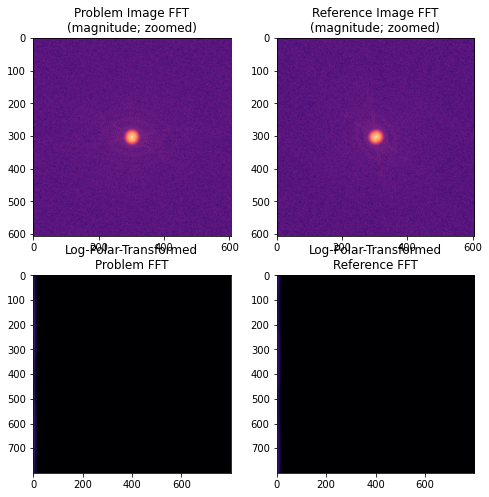

In [82]:
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
import cv2
import numpy as np
import matplotlib.pyplot as plt

theta_num=800
rad_num=800
desired_theta_ac = 360000

def plot(im):
    plt.imshow(im, cmap='gray')
    plt.show()
    
imR=cv2.imread("../EXPERIMENTAL/TEST_IMAGES/IM_5_phiCR_-2.6049387454986572.png", cv2.IMREAD_GRAYSCALE)
imP=cv2.imread("../EXPERIMENTAL/TEST_IMAGES/IM_6_phiCR_-1.7562638521194458.png", cv2.IMREAD_GRAYSCALE)
radius = 2*imR.shape[0]//3
print(imR.shape)
#plot(imP)
imR_polar = warp_polar(imR, center=compute_intensity_gravity_center(imR), 
                       output_shape=(theta_num, rad_num), radius=radius, scaling='linear', order=1) # number of rows will be 2pi
imP_polar = warp_polar(imP, center=compute_intensity_gravity_center(imP), 
                       output_shape=(theta_num,rad_num), radius=radius, scaling='linear', order=1)

'''
         - 0: Nearest-neighbor
         - 1: Bi-linear (default)
         - 2: Bi-quadratic
         - 3: Bi-cubic
         - 4: Bi-quartic
         - 5: Bi-quintic
'''
print(imR_polar.shape)
#plot(imR_polar)
#plot(imP_polar)
#plt.plot(imR_polar.sum(axis=1), 'o', markersize=1)
#plt.show()

# A. Directly register the log-polar images using Fourier phase correlation -> assumes no translational difference present!

# space Defines how the algorithm interprets input data. “real” means data will be FFT’d to compute the correlation, while “fourier” data will bypass FFT of input data. 
# mages will be registered to within 1 / upsample_factor of a pixel.
shifts, error, phasediff = phase_cross_correlation(imR_polar, imP_polar, normalization='phase',
                                             upsample_factor=desired_theta_ac/theta_num,  space='real')
print(shifts, error, phasediff)

gt = (-1.7562638521194458+2.6049387454986572)
found = shifts[0]/theta_num*2*np.pi
print("Found:",found/np.pi*180, "Ground truth", gt/np.pi*180)


# B. Register the Fourier maps of the polar plots! They should be translation invariant!
from scipy.fft import fft2, fftshift
# First, band-pass filter both images
#image = difference_of_gaussians(image, 5, 20)
#rts_image = difference_of_gaussians(rts_image, 5, 20)


# work with shifted FFT magnitudes
imP_F = np.abs(fftshift(fft2(imP)))
imR_F = np.abs(fftshift(fft2(imR)))

# Create log-polar transformed FFT mag images and register
radius = imP_F.shape[0]  # only take lower frequencies
polar_imP_F = warp_polar(imP_F, radius=radius, output_shape=(theta_num, rad_num),
                             scaling='linear', order=1)
polar_imR_F = warp_polar(imR_F, radius=radius, output_shape=(theta_num, rad_num),
                           scaling='linear', order=1)

shifts, error, phasediff = phase_cross_correlation(polar_imR_F, polar_imP_F, normalization='phase',
                            upsample_factor=desired_theta_ac/theta_num,  space='real') # relamente no es real pero bueno xD
found = shifts[0]/theta_num*2*np.pi
print(shifts, error, phasediff)
print("Found:",found/np.pi*180, "Ground truth", gt/np.pi*180)

# Use translation parameters to calculate rotation and scaling parameters

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Problem Image FFT\n(magnitude; zoomed)")
ax[0].imshow(np.log(imP_F+1),
             cmap='magma')
ax[1].set_title("Reference Image FFT\n(magnitude; zoomed)")
ax[1].imshow(np.log(1+imR_F),
             cmap='magma')
ax[2].set_title("Log-Polar-Transformed\nProblem FFT")
ax[2].imshow(polar_imP_F, cmap='magma')
ax[3].set_title("Log-Polar-Transformed\nReference FFT")
ax[3].imshow(polar_imR_F, cmap='magma')
plt.show()



# (F) CNN pelado

# (G) Metric/Embedding como look-up table

# (H) Histogram versión mejorada?

# (I) Usando regresión de una recta con los puntos recogidos en Gradient alg 

In [ ]:
Y benchmarks por:
    - normalizaciones diferentes. En particular con la LUT esa diferentes.
    - por metrica, usando embeddings, umap y/o el trained.
    - usando o no denoiser.
Los tres para el set de datos noisy, el de training, y quizá el non noisy, pero poco o ningíun interes ese último claro

# BENCHMARK

### (a) Using the Experimental+Simulated Test Images

- Jarri falte diren test imagesak.
- Probeu descensoan alg. Ein errorak kendu eta funkionala izen daddin egiñ.
- Implementeu okurrentzi bixek! Probeu en test algs ke tal. Eta ein proba desberdiñek con combos diferentes de threholdings y métricas diferentes (AÑADIR EN ELS GRADIENT Y MIRROR LA OPCIÓN DE ELEGIR LA MÉTRICA!)

> Passing Images from each Algorithm...
Image 0 optimized!
Image 1 optimized!
Image 2 optimized!
Image 3 optimized!
Image 4 optimized!
Image 5 optimized!
Image 6 optimized!
Image 7 optimized!
Image 8 optimized!
Image 9 optimized!
Image 10 optimized!
Image 11 optimized!
Image 12 optimized!
Image 13 optimized!
Image 14 optimized!
Image 15 optimized!
Image 16 optimized!
Image 17 optimized!
Image 18 optimized!
Image 19 optimized!
Image 20 optimized!
Image 21 optimized!
Image 22 optimized!
Image 23 optimized!
Image 24 optimized!
Image 25 optimized!
 - Algorithm Simulation_Coord_Desc_Fibonacci_Ratio_Search done!
Image 0 optimized!
Image 1 optimized!
Image 2 optimized!
Image 3 optimized!
Image 4 optimized!
Image 5 optimized!
Image 6 optimized!
Image 7 optimized!
Image 8 optimized!
Image 9 optimized!
Image 10 optimized!
Image 11 optimized!
Image 12 optimized!
Image 13 optimized!
Image 14 optimized!
Image 15 optimized!
Image 16 optimized!
Image 17 optimized!
Image 18 optimized!
Image 19 optimiz

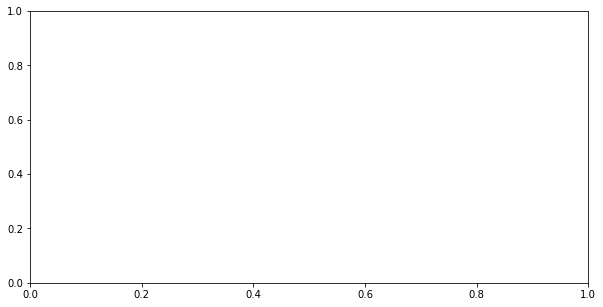

<Figure size 2880x2160 with 0 Axes>

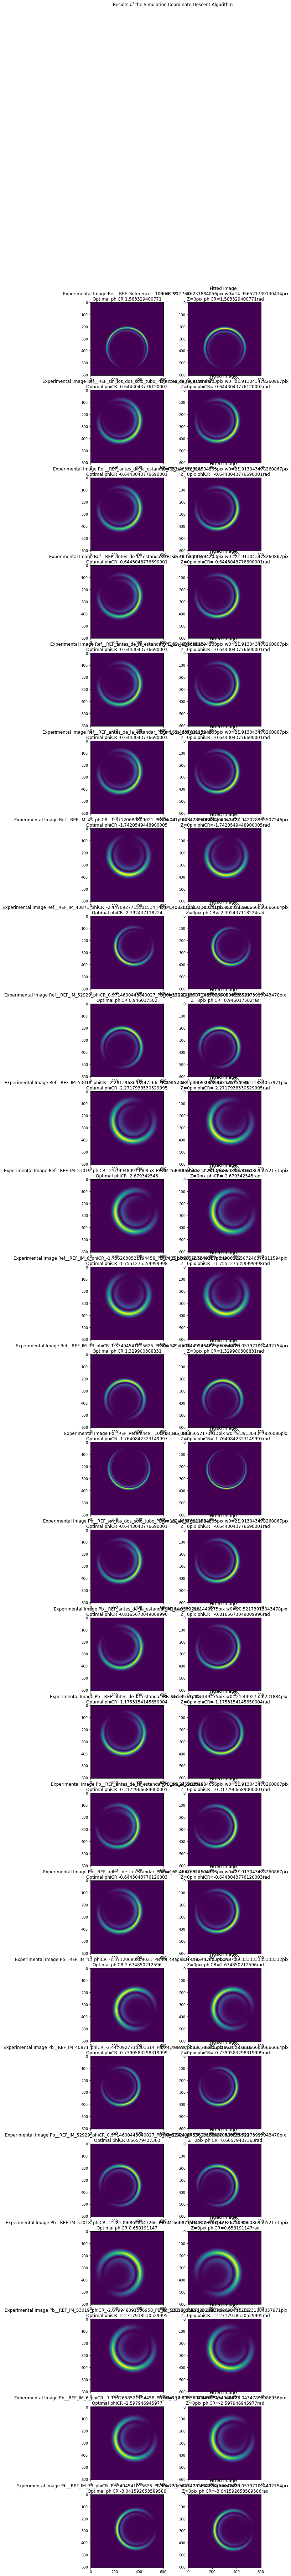

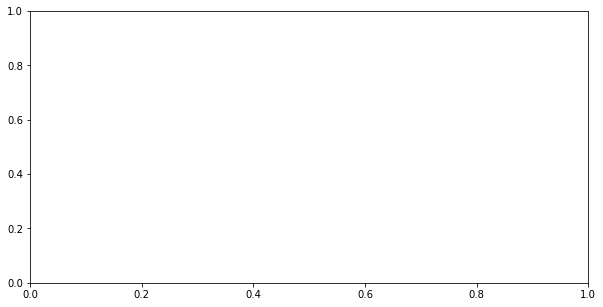

<Figure size 2880x2160 with 0 Axes>

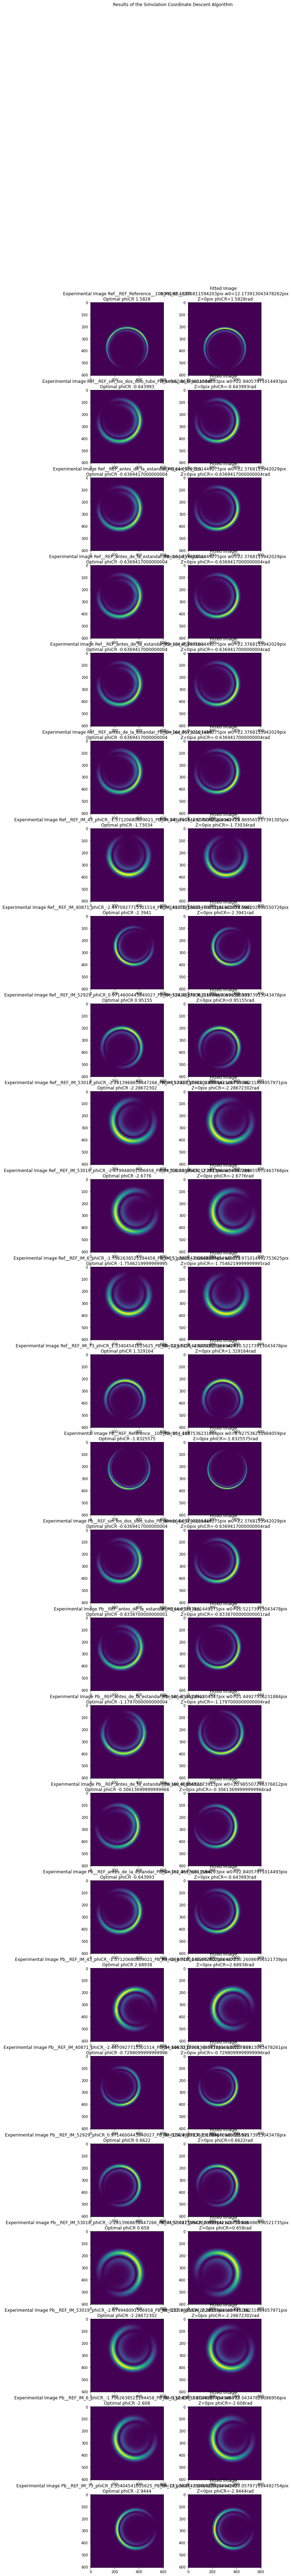

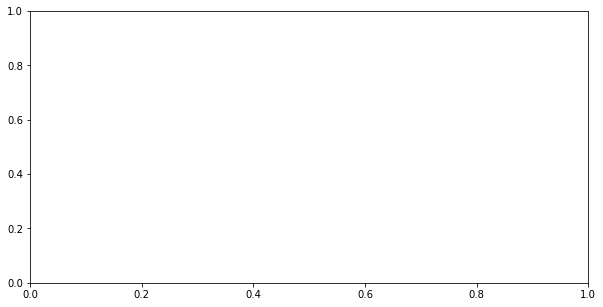

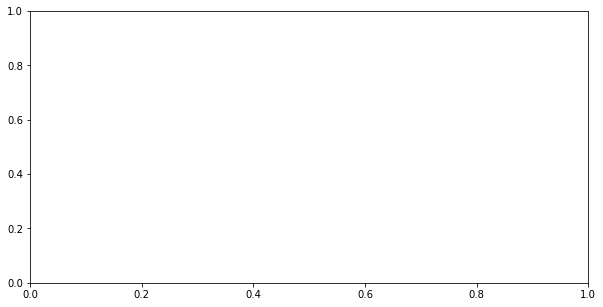

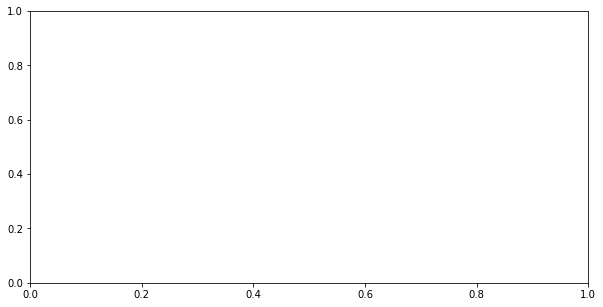

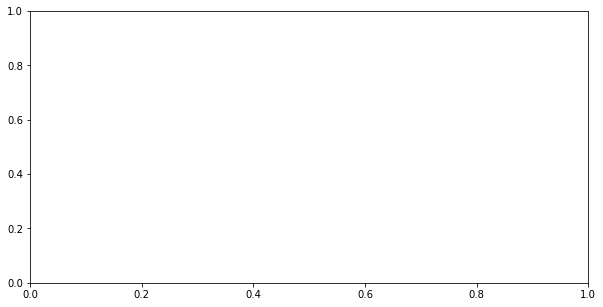

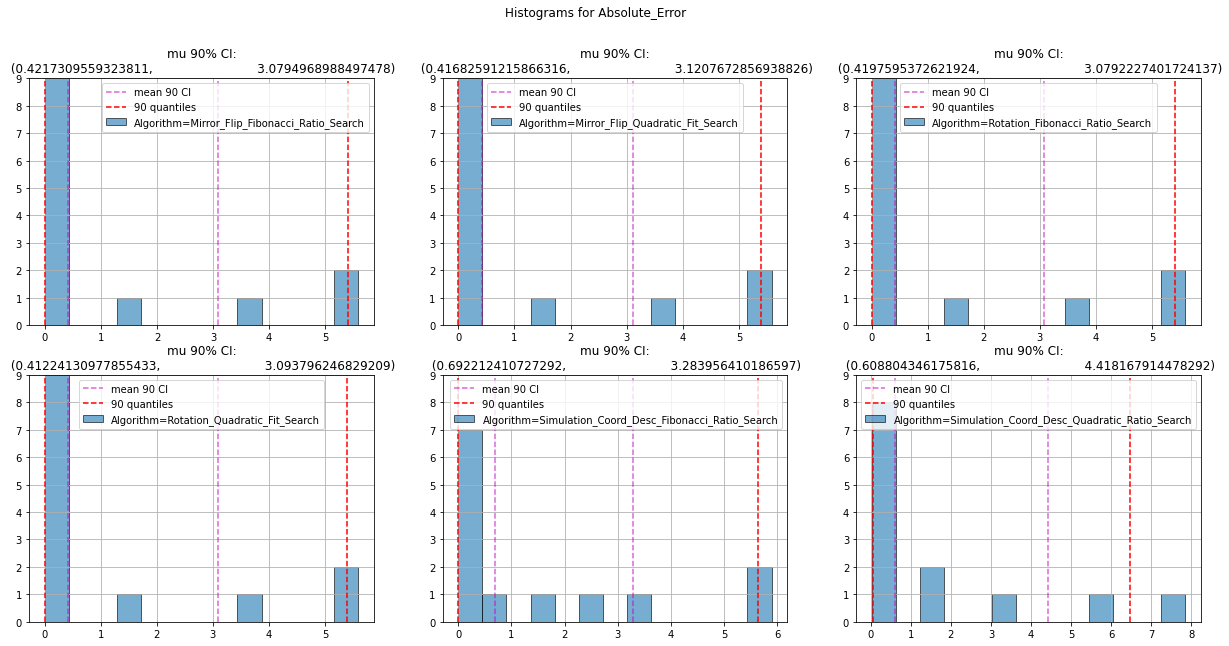

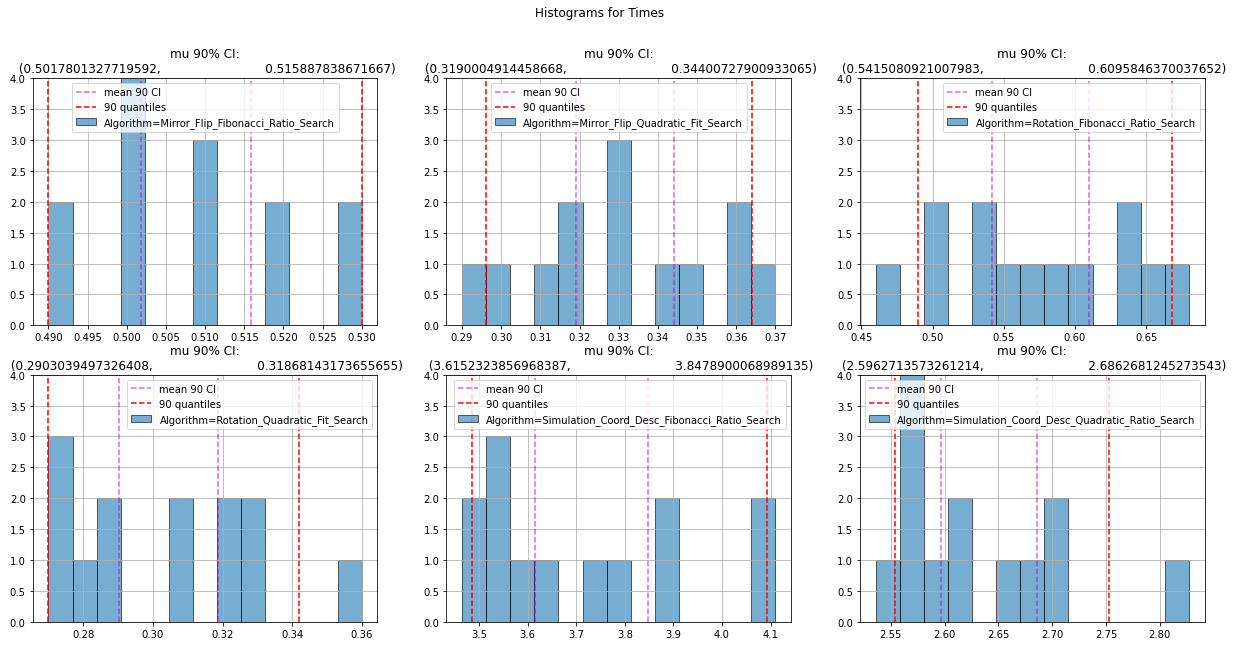

In [15]:
# General pipeline settings
output_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/Feel_the_pipeline/"
output_units = 'deg'
confidence = 90
boots_samples = 10000
X=302
dtype = np.float64
dtype_torch = torch.float64


# Get the Images to Test
images_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/TEST_IMAGES/"
references_names = ['Reference__100', 'sin_los_dos_solo_tubo','antes_de_la_estandar', 'antes_de_la_estandar', 'antes_de_la_estandar', 'antes_de_la_estandar',
                   'IM_43_phiCR_-1.57120680809021','IM_40871_phiCR_-2.4470927715301514','IM_52929_phiCR_0.9714600443840027','IM_53018_phiCR_-2.2813968658447266',
                   'IM_53019_phiCR_-2.679948091506958', 'IM_6_phiCR_-1.7562638521194458', 'IM_73_phiCR_1.33404541015625']
respective_pb_names = ['90__100',  'antes_de_la_estandar','con_los_dos', 'sin_el_negativo','sin_el_positivo','sin_los_dos_solo_tubo',
                       'IM_44_phiCR_2.6544740200042725', 'IM_40870_phiCR_-0.6731816530227661', 'IM_52928_phiCR_0.6789670586585999', 'IM_53017_phiCR_0.659442126750946',
                       'IM_53018_phiCR_-2.2813968658447266', 'IM_5_phiCR_-2.6049387454986572', 'IM_72_phiCR_-2.946422576904297']

image_pair_names = []
sam_im = cv2.imread( f"{images_path}/{references_names[0]}.png", cv2.IMREAD_GRAYSCALE)

references = np.zeros((len(references_names), sam_im.shape[0], sam_im.shape[1]), dtype=dtype)
problems = np.zeros((len(references_names), sam_im.shape[0], sam_im.shape[1]), dtype=dtype)
for k, (refn, pbn) in enumerate(zip(references_names, respective_pb_names)):
    image_pair_names.append(f"REF_{refn}_PB_{pbn}")
    references[k] = cv2.imread( f"{images_path}/{refn}.png", cv2.IMREAD_GRAYSCALE)
    problems[k] = cv2.imread( f"{images_path}/{pbn}.png", cv2.IMREAD_GRAYSCALE)

# Get their pb-ref ground truths
ground_truths = np.array([90, 0,-4.4, -13.85, 9.45, 0.0,
            angle_to_pi_pi(2.6544740200042725+1.57120680809021)*180/np.pi/2, angle_to_pi_pi(-0.6731816530227661+2.4470927715301514)*180/np.pi/2, angle_to_pi_pi(0.6789670586585999-0.9714600443840027)*180/np.pi/2, angle_to_pi_pi(0.659442126750946+2.2813968658447266)*180/np.pi/2,angle_to_pi_pi(-2.2813968658447266+2.679948091506958)*180/np.pi/2, angle_to_pi_pi(-2.6049387454986572+1.7562638521194458)*180/np.pi/2, angle_to_pi_pi(-2.946422576904297-1.33404541015625)*180/np.pi/2 
                        ])
GT_units = 'deg'
GT_nature = 'pol'
table_per_alg={}
table_per_image={}
exp_names=['Normalize_to_Max', 'Normalize_to_average', 'Sigmoid de parametros tal y cual']
# List the Algorithms to test
for exp_name in exp_names:
    algorithm_lambda_list = [

        lambda refs, pbs, dir_alg : run_simulation_algorithm(references=refs, problems=pbs,
                    image_pair_names=image_pair_names, preprocess_fct=simulation_preprocess_fct,
                    search_algorithm="fibonacci", search_alg_kw_args=simulation_fibo_kw_args,
                    simulation_alg_kw_args=simulation_alg_kw_args, out_plot_path=dir_alg, simulation_algorithm=None,
                    mirror_alg_kw_args=mirror_alg_sim_kw_args),

        lambda refs, pbs, dir_alg : run_simulation_algorithm(references=refs, problems=pbs,
                    image_pair_names=image_pair_names, preprocess_fct=simulation_preprocess_fct,
                    search_algorithm="quadratic", search_alg_kw_args=simulation_quad_kw_args,
                    simulation_alg_kw_args=simulation_alg_kw_args, out_plot_path=dir_alg, simulation_algorithm=None,
                                        mirror_alg_kw_args=mirror_alg_sim_kw_args),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=mirror_preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=mirror_fibo_kw_args,
                        mirror_alg_kw_args=mirror_alg_kw_args, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=rotation_preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=rotation_fibo_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=mirror_preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=mirror_quad_kw_args,
                        mirror_alg_kw_args=mirror_alg_kw_args, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=rotation_preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=rotation_quad_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

    ]

    # Label for the name of each algorithm to try in the pipeline
    algorithm_name_list = [
        "Simulation_Coord_Desc_Fibonacci_Ratio_Search",
        "Simulation_Coord_Desc_Quadratic_Ratio_Search",
        "Mirror_Flip_Fibonacci_Ratio_Search",
        "Rotation_Fibonacci_Ratio_Search",
        "Mirror_Flip_Quadratic_Fit_Search",
        "Rotation_Quadratic_Fit_Search"    
    ]


    # Run the pipeline!
    table_per_image[exp_name], table_per_alg[exp_name] = run_benchmark_output_result_histograms_and_result_table(
        algorithm_lambda_list=algorithm_lambda_list, algorithm_name_list=algorithm_name_list,
        references=references, problems=problems, image_pair_names=image_pair_names,
        generate_algorithm_plots=True,
        generate_histograms=True, boots_samples=boots_samples, confidence=confidence,
        output_units=output_units, ground_truths=ground_truths, GT_units=GT_units,
        GT_nature = GT_nature,
        experiment_name = exp_name, 
        output_path=output_path)

# Generate Excel files!
# Excel for algorithms
writer = StyleFrame.ExcelWriter(f'{output_path}/EXCEL_Results_per_Algorithm.xlsx')
for exp_name in exp_names:
    StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name=exp_name, startcol=1)
    StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name=exp_name, startcol=5)
    sf = StyleFrame(pd.DataFrame(table_per_alg[exp_name].index.get_level_values(0)))
    sf.set_column_width(columns=[1], width=55.0)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1)
    sf = StyleFrame(table_per_alg[exp_name]['Absolute_Error'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1, startcol=1, float_format="%.5f")
    sf = StyleFrame(table_per_alg[exp_name]['Times'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
    sf.to_excel(writer, sheet_name=exp_name,  startrow=1, startcol=5, float_format="%.5f")
writer.save()

# Excel for images
writer = StyleFrame.ExcelWriter(f"{output_path}/EXCEL_Results_per_Image.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
for exp_name in exp_names:
    StyleFrame(table_per_image[exp_name]).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image[exp_name].columns), sheet_name=exp_name, index=False,  float_format="%.8f")
writer.save()



In [16]:
table_per_alg # menos precision en fibo

Absolute_Error               \
                                                       Mean Standard_Dev   
Algorithm                                                                  
Mirror_Flip_Fibonacci_Ratio_Search                 1.280924     2.089442   
Mirror_Flip_Quadratic_Fit_Search                   1.281958     2.088206   
Rotation_Fibonacci_Ratio_Search                    1.284378     2.088828   
Rotation_Quadratic_Fit_Search                      1.281532     2.089090   
Simulation_Coord_Desc_Fibonacci_Ratio_Search       1.577105     2.114033   
Simulation_Coord_Desc_Quadratic_Ratio_Search       1.589771     2.484153   

                                                                     Times  \
                                             CI_90_low  CI_90_up      Mean   
Algorithm                                                                    
Mirror_Flip_Fibonacci_Ratio_Search            0.421731  3.079497  0.508462   
Mirror_Flip_Quadratic_Fit_Search              0.416826  3.120767  0.331538   
Rotation_Fibonacci_Ratio_Search               0.419760  3.079223  0.574615   
Rotation_Quadratic_Fit_Search                 0.412241  3.093796  0.303846   
Simulation_Coord_Desc_Fibonacci_Ratio_Search  0.692212  3.283956  3.712154   
Simulation_Coord_Desc_Quadratic_Ratio_Search  0.608804  4.418168  2.630769   

                                                                               
                                             Standard_Dev CI_90_low  CI_90_up  
Algorithm                                                                      
Mirror_Flip_Fibonacci_Ratio_Search               0.013445  0.501780  0.515888  
Mirror_Flip_Quadratic_Fit_Search                 0.024099  0.319000  0.344007  
Rotation_Fibonacci_Ratio_Search                  0.065398  0.541508  0.609585  
Rotation_Quadratic_Fit_Search                    0.028148  0.290304  0.318681  
Simulation_Coord_Desc_Fibonacci_Ratio_Search     0.216358  3.615232  3.847890  
Simulation_Coord_Desc_Quadratic_Ratio_Search     0.081230  2.596271  2.686268

In [17]:
table_per_image[:30]

,ID,Image_Pair_Name,Algorithm,Predicted_Delta_PhiCRs,Pred_Delta_Polarizt,Times,Ground_Truth_pol,Absolute_Error
0,0,REF_Reference__100_PB_90__100,Simulation_Coord_Desc_Fibonacci_Ratio_Search,1.682073e+02,8.410366e+01,4.110,90.00,5.896337e+00
1,0,REF_Reference__100_PB_90__100,Simulation_Coord_Desc_Quadratic_Ratio_Search,1.643144e+02,8.215721e+01,2.612,90.00,7.842785e+00
2,0,REF_Reference__100_PB_90__100,Mirror_Flip_Fibonacci_Ratio_Search,1.694375e+02,8.471876e+01,0.530,90.00,5.281237e+00
3,0,REF_Reference__100_PB_90__100,Rotation_Fibonacci_Ratio_Search,1.694447e+02,8.472233e+01,0.460,90.00,5.277672e+00
4,0,REF_Reference__100_PB_90__100,Mirror_Flip_Quadratic_Fit_Search,1.694396e+02,8.471982e+01,0.360,90.00,5.280176e+00
5,0,REF_Reference__100_PB_90__100,Rotation_Quadratic_Fit_Search,1.694543e+02,8.472715e+01,0.320,90.00,5.272851e+00
6,1,REF_sin_los_dos_solo_tubo_PB_antes_de_la_estandar,Simulation_Coord_Desc_Fibonacci_Ratio_Search,-3.265844e-09,-1.632922e-09,3.730,0.00,1.632922e-09
7,1,REF_sin_los_dos_solo_tubo_PB_antes_de_la_estandar,Simulation_Coord_Desc_Quadratic_Ratio_Search,4.040097e-01,2.020049e-01,2.666,0.00,2.020049e-01
8,1,REF_sin_los_dos_solo_tubo_PB_antes_de_la_estandar,Mirror_Flip_Fibonacci_Ratio_Search,9.778442e-05,4.889221e-05,0.530,0.00,4.889221e-05
9,1,REF_sin_los_dos_solo_tubo_PB_antes_de_la_estandar,Rotation_Fibonacci_Ratio_Search,-2.350265e-02,-1.175133e-02,0.580,0.00,1.175133e-02


In [18]:
table_per_image

,ID,Image_Pair_Name,Algorithm,Predicted_Delta_PhiCRs,Pred_Delta_Polarizt,Times,Ground_Truth_pol,Absolute_Error
0,0,REF_Reference__100_PB_90__100,Simulation_Coord_Desc_Fibonacci_Ratio_Search,168.207327,84.103663,4.110,90.000000,5.896337
1,0,REF_Reference__100_PB_90__100,Simulation_Coord_Desc_Quadratic_Ratio_Search,164.314430,82.157215,2.612,90.000000,7.842785
2,0,REF_Reference__100_PB_90__100,Mirror_Flip_Fibonacci_Ratio_Search,169.437526,84.718763,0.530,90.000000,5.281237
3,0,REF_Reference__100_PB_90__100,Rotation_Fibonacci_Ratio_Search,169.444655,84.722328,0.460,90.000000,5.277672
4,0,REF_Reference__100_PB_90__100,Mirror_Flip_Quadratic_Fit_Search,169.439647,84.719824,0.360,90.000000,5.280176
...,...,...,...,...,...,...,...,...
73,12,REF_IM_73_phiCR_1.33404541015625_PB_IM_72_phiC...,Simulation_Coord_Desc_Quadratic_Ratio_Search,115.142819,57.571410,2.568,57.373625,0.197785
74,12,REF_IM_73_phiCR_1.33404541015625_PB_IM_72_phiC...,Mirror_Flip_Fibonacci_Ratio_Search,114.746264,57.373132,0.500,57.373625,0.000493
75,12,REF_IM_73_phiCR_1.33404541015625_PB_IM_72_phiC...,Rotation_Fibonacci_Ratio_Search,114.738955,57.369477,0.540,57.373625,0.004148
76,12,REF_IM_73_phiCR_1.33404541015625_PB_IM_72_phiC...,Mirror_Flip_Quadratic_Fit_Search,114.744084,57.372042,0.320,57.373625,0.001583


In [148]:
from styleframe import StyleFrame

writer = StyleFrame.ExcelWriter(f"{output_path}/EXCEL_full_data.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
StyleFrame(table_per_image).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image.columns), sheet_name=f'Pene!', index=False,  float_format="%.8f")
writer.save()

In [93]:
df2 = table_per_alg.droplevel(0, axis=1)
df2

,Mean,Standard_Dev,CI_90_low,CI_90_up,Mean,Standard_Dev,CI_90_low,CI_90_up
Algorithm,,,,,,,,
Mirror_Flip_Fibonacci_Ratio_Search,1.280924,2.089442,0.421731,3.079497,0.508462,0.013445,0.501780,0.515888
Mirror_Flip_Quadratic_Fit_Search,1.281958,2.088206,0.416826,3.120767,0.331538,0.024099,0.319000,0.344007
Rotation_Fibonacci_Ratio_Search,1.284378,2.088828,0.419760,3.079223,0.574615,0.065398,0.541508,0.609585
Rotation_Quadratic_Fit_Search,1.281532,2.089090,0.412241,3.093796,0.303846,0.028148,0.290304,0.318681
Simulation_Coord_Desc_Fibonacci_Ratio_Search,1.577105,2.114033,0.692212,3.283956,3.712154,0.216358,3.615232,3.847890
Simulation_Coord_Desc_Quadratic_Ratio_Search,1.589771,2.484153,0.608804,4.418168,2.630769,0.081230,2.596271,2.686268


In [118]:
a=table_per_alg['Absolute_Error']
a['Algorithm']

KeyError: 'Algorithm'

In [139]:
pd.DataFrame(table_per_alg.index.get_level_values(0))

,Algorithm
0,Mirror_Flip_Fibonacci_Ratio_Search
1,Mirror_Flip_Quadratic_Fit_Search
2,Rotation_Fibonacci_Ratio_Search
3,Rotation_Quadratic_Fit_Search
4,Simulation_Coord_Desc_Fibonacci_Ratio_Search
5,Simulation_Coord_Desc_Quadratic_Ratio_Search


In [147]:
writer = StyleFrame.ExcelWriter(f'{output_path}/PythonExport.xlsx')
StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name='Sheet1', startcol=1)
StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name='Sheet1', startcol=5)
sf = StyleFrame(pd.DataFrame(table_per_alg.index.get_level_values(0)))
sf.set_column_width(columns=[1], width=55.0)
sf.to_excel(writer, sheet_name='Sheet1', startrow=1)
sf = StyleFrame(table_per_alg['Absolute_Error'])
sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
sf.to_excel(writer, sheet_name='Sheet1', startrow=1, startcol=1, float_format="%.5f")
sf = StyleFrame(table_per_alg['Times'])
sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
sf.to_excel(writer, sheet_name='Sheet1',  startrow=1, startcol=5, float_format="%.5f")

writer.save()


yastaaaaa!!!!

In [64]:
df1 = pd.DataFrame(columns=table_per_alg.droplevel([1], axis=1).columns)
df1.columns

Index(['Absolute_Error', 'Absolute_Error', 'Absolute_Error', 'Absolute_Error',
       'Times', 'Times', 'Times', 'Times'],
      dtype='object')

In [88]:
writer = StyleFrame.ExcelWriter(f"{output_path}/EXCEL_full_data.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
StyleFrame(table_per_alg).set_row_height(1,50).to_excel(writer, startrow=1, best_fit=list(range(1,len(table_per_alg.columns)+1)), sheet_name=f'Pene!', index=False,  float_format="%.8f")
#StyleFrame(df2).set_row_height(1,50).to_excel(writer, best_fit=list(df2.columns), sheet_name=f'Pene!', index=False,  float_format="%.8f")
writer.save()

KeyError: 1

In [35]:
a=np.array(table_per_alg.columns)
a

array([('Absolute_Error', 'Mean'), ('Absolute_Error', 'Standard_Dev'),
       ('Absolute_Error', 'CI_90_low'), ('Absolute_Error', 'CI_90_up'),
       ('Times', 'Mean'), ('Times', 'Standard_Dev'),
       ('Times', 'CI_90_low'), ('Times', 'CI_90_up')], dtype=object)

In [41]:
table_per_alg[['Absolute_Error']]

Absolute_Error               \
                                                       Mean Standard_Dev   
Algorithm                                                                  
Mirror_Flip_Fibonacci_Ratio_Search                 1.280924     2.089442   
Mirror_Flip_Quadratic_Fit_Search                   1.281958     2.088206   
Rotation_Fibonacci_Ratio_Search                    1.284378     2.088828   
Rotation_Quadratic_Fit_Search                      1.281532     2.089090   
Simulation_Coord_Desc_Fibonacci_Ratio_Search       1.577105     2.114033   
Simulation_Coord_Desc_Quadratic_Ratio_Search       1.589771     2.484153   

                                                                  
                                             CI_90_low  CI_90_up  
Algorithm                                                         
Mirror_Flip_Fibonacci_Ratio_Search            0.421731  3.079497  
Mirror_Flip_Quadratic_Fit_Search              0.416826  3.120767  
Rotation_Fibonacci_Ratio_Search               0.419760  3.079223  
Rotation_Quadratic_Fit_Search                 0.412241  3.093796  
Simulation_Coord_Desc_Fibonacci_Ratio_Search  0.692212  3.283956  
Simulation_Coord_Desc_Quadratic_Ratio_Search  0.608804  4.418168

Vale parece que si se decanta por el lado equivocado convergera en un minimo equivocado tanto el quadratic como el fibonacci, porke es multimodal la funcion de coste. Para evitarlo podriamos hace runa fase de exploración inicial probando no se, 10 diferentes angulos equidistantes en el rango y de ellos elegir los tres primeros para hacer la primera exploración eligiendo los más altos de frontera y en medio poner el que sea más bajo. Si no tmabién se podría probar con otras métricas de similitud, probar la mae, la similarity CNN etc.
Y si no hacer BF directamente claro.

### (b) Using a large simulated Noisy Image Library